# Practical 2 - CMP gathers, NMO corrections and semblance velocity analysis 

In this exercise we will view firstly a synthetic CMP gather and then a real CMP gather and conduct an NMO correction. By working through the exercise you will learn how to conduct semblance analysis to determine the correct velocity profile to use for NMO corrections of a full seismic trace. As you work on the exercise think about how data science and artificial intelligence may be able to improve on these standard workflows.

**Learning Objectives**:
1)	Understand gathers and their physical components
2)	Understand how pre-stack datasets are formatted and how to view them
3)	Understand how and why we need to do NMO corrections


In [26]:
# import required libraries
%matplotlib inline
from scipy.interpolate import CubicSpline  # For  interpolation functions
import matplotlib.pyplot as plt
import seismic.additional_functions as seis # library created for the purpose of this lecture series, explore further if interested!
import numpy as np
import segyio
import os

## 2.1 Load a synthetic CMP gather

In this part of the exercise a synthetic CMP gather will be loaded, which has been produced by Leonardo Uieda. Check out his Github tutorial which has heavily inspired this exercise. https://github.com/pinga-lab/nmo-tutorial/blob/master/step-by-step-nmo.ipynb . The synthetic CMP gather is already stored in a compressed Numpy format. We will learn more about the SEG-Y format which is often used for storing seismic data tomorrow. 

In [39]:
# point to data
file = 'synthetic_cmp.npz'
assert os.path.exists(file), 'file cannot be found on given path'

In [40]:
# load data
data = np.load(file)
print("Data in the archive:", list(data.keys()))

Data in the archive: ['dt', 'offsets', 'CMP']


In [41]:
# separate data arrays for clarity and extract key info
dt = data['dt'] # timestep 
offsets = data['offsets']  #receivers/traces offsets/distance
cmp = data['CMP'] # data for each trace
nsamples = cmp.shape[0] # number of datapoints on each trace
noffsets = cmp.shape[1] # number of traces
times = np.arange(nsamples)*dt # time axis (proportional to depth)

assert noffsets == len(offsets), 'traces in cmp and offsets key do not match size'

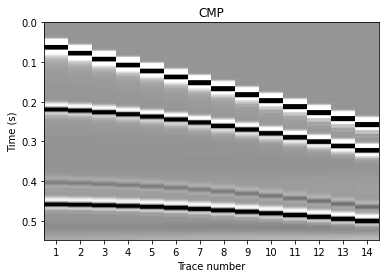

In [42]:
seis.plot(cmp,noffsets, nsamples,dt)

**QUESTION: What seismic events can you see in this CMP gather? This is worth discussing with your peers.**

from top to bottom:
1) The direct wave
2) The reflection from the first interface
3) A multiple reflection from the first interface
4) The reflection from second interface

## 2.2. Conducting the NMO correction with prescribed velocities

In this section you will learn how to conduct an NMO correction for NMO velocities that we know are correct. If you work through this section correctly the outcome should be a CMP gather with horizontal reflections, but before starting to code work your way through the NMO exercise below to build and intuition of how this method works

**QUESTION: You are provided with an example of a typical CMP gather (Records 7). All sources and receivers can be assumed to be at the Earth’s surface. Record 7 shows a land record in which the source was dynamite. This gather contains 96 traces with a 25 m trace spacing.**

![NMO](NMO.png)!NMO](NMO.png)

**1) Calculate the NMO velocities of reflections A and B**

**2) What is the near-surface velocity given by the direct arrival A?**

**3) What is the near-surface velocity given by the direct arrival C? Do you have any suggestions of what arrival C could be?**


Lets move on to automating this method for our gathers

In [24]:
# known velocities, see later how these are obtained in reality
v1, t1 = 3800, 0.22
v2, t2 = 4800, 0.46

# create velocity profile for section. This will be used for the correction, different layers require different velocities to be corrected well
v_nmo = v1 + ((v2 - v1)/(t2 - t1))*(times - t1)  # equation for a straight line between two points.

NameError: name 'times' is not defined

**Question: Complete the provided NMO functions below**

the algorithm for NMO correction is described below to aid your undertanding:
1. Start with an NMO gather filled with zeros
2. for each point ($t_0, x$) in the NMO gather do:
    - calculate the reflection travel-time $t = \sqrt{t_0 ^{2} + \frac{x ^{2}}{v_{NMO} ^{2}}}  $
    - go to the trace at offset $x$ and find the amplitude we want to shift-up/correct
    - place this amplitude in the current position ($t_0, x$)

In [67]:
def nmo_correction(cmp, dt, offsets, velocities, times):
    """
    Returns
    -------
    
    nmo : 2D array
        The NMO corrected gather.
    """
    
    nmo = np.zeros_like(cmp) #set array for corrected data

    for i, t0 in enumerate(times): # index, timestep
        for j, x in enumerate(offsets): # index, offset
            # find the travel-time for a specific reflection on a trace
            t = reflection_time(t0, x, velocities[i]) 
                                   
            # find the amplitude value we want to shift to our current position
            try: amplitude = -------complete----- # find correct amplitude
            except: amplitude = None #if outside of cmp time range
            
            # place sampled amplitude at current position
            if amplitude is not None:
                nmo[i, j] = amplitude
    return nmo

def reflection_time(t0, x, vnmo):
    """
    Calculate the travel-time of a reflected wave.
    """
    # in class seen equation for expected time shift in trace
    t =  --------complete-------
    return t

In [68]:
nmo = nmo_correction(cmp, dt, offsets, v_nmo, times)

In [69]:
# only run if you cannot get the nmo correction working yourself!
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo)

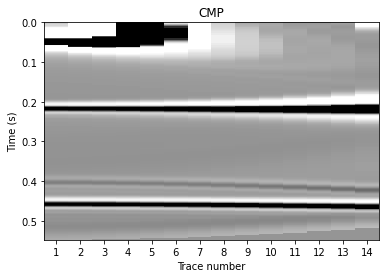

In [70]:
seis.plot(nmo, noffsets, nsamples,dt)

**QUESTION: Do you notice anything strange about the first arrival? What might be going on here?**

[answer] the first arrival is a direct arrival rather than a reflection. Reflection travel times are not governed by the hyperbolic travel time equation therefore application of this equation does not make this arrival horizontal. In seismic data processing the direct arrival and also any head waves will be removed by a “mute” (basically they are chopped out of the corrected gathers before stacking). 

**QUESTION: Could you propose a simple way of testing whether the 3rd arrival seen is actually a multiple of the first reflection?**

[answer] Simply changing v2 in our code to 3800 would lead to a constant velocity profile and show both the 2nd and 3rd reflection perfectly horizontal, showing that they have the same NMO velocity. The second give away would be the large fall in energy seen between the 2nd the 3rd arrival. Finally, if you look closely, the polarity of the reflection is also reversed compared to the 1st reflection. 

The purpose of the NMO correction is so that reflections from different source-receiver pairs that image the same point in the subsurface (common depth point- CDP) can be combined (stacked) to improve the signal to noise ratio. Now that our CMP has been NMO corrected we can sum (stack) the signals across traces in a CMP gather. This is visualised below.

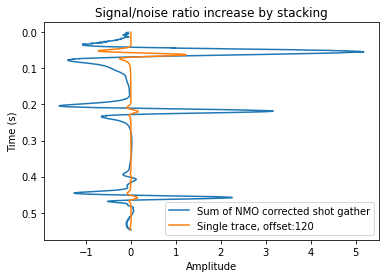

In [9]:
plt.plot(np.sum(nmo, axis = 1), times, label='Sum of NMO corrected shot gather')
plt.plot(cmp[:,0], times, label='Single trace, offset:' + str(offsets [0]))
plt.title("Signal/noise ratio increase by stacking")
plt.ylabel('Time (s)')
plt.xlabel('Amplitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Note that due to the use of a synthetic CMP there is a lack of noise, but we can still appreciate how the amplitudes can increase after stacking. Since noise is partially random it will not sum up like amplitudes, we say partially here because multiples for instance are also a source of noise in the data and they can be predicted! In seismic data processing we need to pick the velocities carefully so we only pick velocities for reflections, not multiples. IF this is done well the multiples will not be properly NMO corrected and therefore will not stack well (ie they will then have low amplitudes in stacked sections and be less of a problem).

## 2.3. Conducting a semblance analysis to determine NMO velocities

In reality, in order to find the correct NMO velocities for a full seismic trace we would need to do something called 'semblance analysis'. This involves computing and applying NMO corrections for a wide range of velocities from lower than expected for the study area to higher. A calculation is done to assess the success of the NMO correction. In our simple example we are going to stack the NMO corrected gathers and calculate the maximum amplitude. When we have computed the NMO velocities correctly for a particular reflector we will get the highest stacked amplitudes. Doing this for all reflections within the seismic trace produces a semblance plot from which a seismic data processor can, in most cases manually, select the correct velocities to use.

**QUESTION: produce a semblance analysis tool yourself to determine the NMO velocities of the reflections in the synthetic CMP gather in section 2.2**

pseudo-code:

- we iterate over a range of velocities
    - this velocity is taken as being constant for the full depth/trace
    - an NMO correction is conducted with this on the section
    - the NMO adjusted traces are all summed across the time dimension and stored
- plot the velocity against time(/depth), showing the sum of the amplitudes at each point
    - imshow function is great for this!
    
again, a starting piece of code is provided, however if you do not manage to make his work, you can again use the provided code two cells down to run our pre-written semblance function

In [ ]:
num = 10 # number of velocities to be test (semblance plot resolution)
v_test = np.linspace(1000, 7000, num) # V testing range: [minimum velocity, maximum velocity, number of intervals/steps]

def semblance(v_test, ......):
    
    
    return semblance_arr

# run the semblance function

# plot the outputs (imshow)

In [71]:
# do run this cell to keep constant formatting of our outputs in this program

num = 10 # number of velocities to be test (semblance plot resolution)
v_test = np.linspace(1000, 7000, num) # V testing range: [minimum velocity, maximum velocity, number of intervals/steps]

amp_store = seis.semblance(v_test, cmp, dt, offsets, times, verbose = True)

progress =  10.0 %
progress =  20.0 %
progress =  30.0 %
progress =  40.0 %
progress =  50.0 %
progress =  60.0 %
progress =  70.0 %
progress =  80.0 %
progress =  90.0 %
progress =  100.0 %


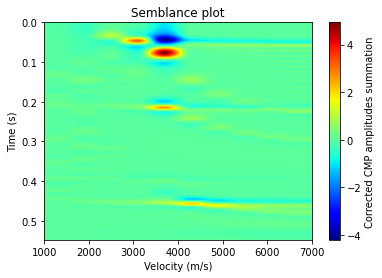

In [12]:
plt.imshow(np.swapaxes(amp_store,0,1), extent=[np.min(v_test), np.max(v_test),
                                            np.max(times), 0], aspect="auto",cmap='jet')
plt.title ('Semblance plot')
plt.colorbar(label = 'Corrected CMP amplitudes summation')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time (s)')
plt.show()

## 2.4 Picking the correct NMO velocities

In this section we have developed a tool to allow you to manually pick the correct velocities for NMO analysis and apply them. If you are feeling adventurous feel free to write your own functions to carry out this process once you are done with the practical

In [36]:
NMO_val = seis.click(amp_store, v_test, times) # right click to obtain data, escape to close window
v_nmo = seis.vel_curve (amp_store, NMO_val, times) # create array containing velocity profile
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo) # carry out correction

IndexError: list index out of range

the observed velocity profile is just a simple piecewise linear function example, we could use more complex functions to fit between velocities. Feel free to implement an alternative fitting function if you have extra time! For some ideas see: https://reproducibility.org/RSF/book/jsg/avo/paper_html/node7.html

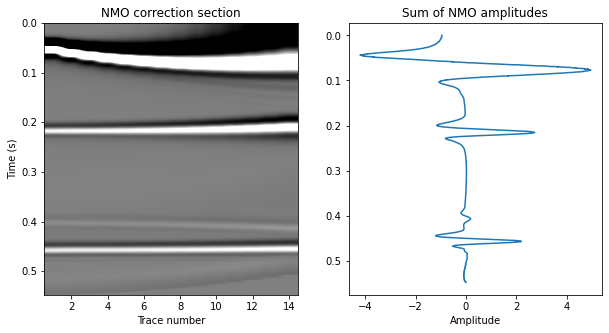

In [14]:
# show results
fig, ax = plt.subplots(1,2, figsize=(10, 5))

# cut-off outliers of data for better visualisation
vm = np.percentile(nmo, 95)
vmin, vmax = -vm, vm

ax[0].imshow(nmo, extent=[0.5, noffsets + 0.5, np.max(times), 0], 
          aspect="auto", cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title('NMO correction section')
ax[0].set_xlabel('Trace number')
ax[0].set_ylabel('Time (s)')

ax[1].plot(np.sum(nmo, axis = 1), times)
ax[1].set_title('Sum of NMO amplitudes')
ax[1].set_xlabel('Amplitude')
ax[1].invert_yaxis()

plt.show()

**QUESTION: How do your picked velocities compare to those you were given in section 2.2? How does the precision with which you can select velocities vary with depth?**

[ANSWER] When we do an NMO correction we are effectively determining which velocity produces a hyperbola to best fit a reflection. Hyperbolas associated with low velocities are much tighter and the range of velocities that can fit them narrower.  Hyperbolas associated with high velocities are much broader and a wide range of velocities can fit them. Therefore, the precision with which we can pick velocities decreases with depth as hyperbolas broaden. 

## 2.5 Conducting NMO corrections with a real CMP gather

In this section you will load a segy file of a real CMP gather and conduct your own NMO correction, courtesy of Rob allen from the VoilA project. You will quickly see that the reality of the situation is more complex then our examples above and there is a need to develop better methods to cope with real seismic data. 

this first section will walk you through how to read in the data, an understanding of how the segyio package works will be developed on Thursday. Once the data is read in, use your prior written functions or the prewritten functions to try and obtain an NMO correction section.

In [37]:
# pointer to data
file = 'VoiLALine1_CDP4000_RA.segy'
assert os.path.exists(file), 'file cannot be found on given path' 

# load data
f = segyio.open(file, ignore_geometry= False) #opens files like python default open call

# extract data from file
data = f.trace.raw[:].T

In [38]:
# get key parameters from dataset
dt = (f.samples[1] - f.samples[0]) / 1000 # timestep in s
offsets = abs(f.offsets) #number of receivers / traces
cmp = data # data for each trace
nsamples = cmp.shape[0]
noffsets = cmp.shape[1]
times = np.arange(nsamples)*dt # times

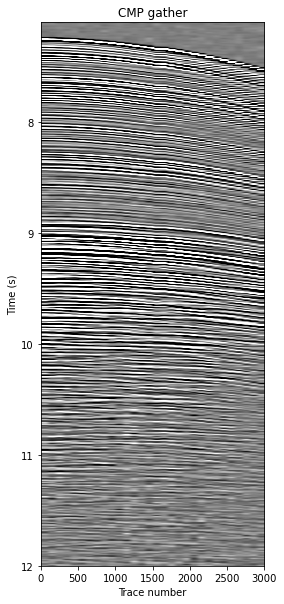

In [39]:
#set cut-off for better visualisation
vm = np.percentile(data, 95)
vmin, vmax = -vm, vm

# set correct axis ranges
extent = [0, data.shape[0], np.max(times), 7.1]
cut = 7100 #starting point in y-axis, no data above this time due to shot/receiver gap
start = int((cut/np.max(f.samples)) * np.shape(data)[0]) #index value for cut

plt.figure(figsize = (4,10))
plt.imshow(data[start:,:], extent= extent, aspect = 'auto', cmap='gray', vmin=vmin, vmax=vmax)
plt.title('CMP gather')
plt.xlabel('Trace number')
plt.ylabel('Time (s)')
plt.show()

**QUESTION: try around some velocities that are too low and too high to see the impact, can you explain what happens at these ranges?**

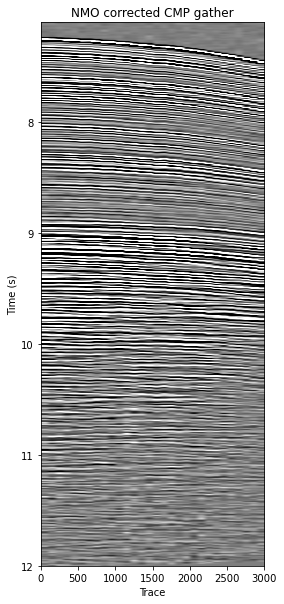

In [50]:
vel = 3000 # vary values (as a minimum try 1000, 1500, 3000)

v_nmo = np.ones(len(times))*vel # constant velocity array for NMO correction
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo) # NMO correction
    
plt.figure(figsize = (4,10))
plt.imshow(nmo[start:,:], extent= extent, aspect = 'auto', cmap='gray', vmin=vmin, vmax=vmax)
plt.title('NMO corrected CMP gather')
plt.xlabel('Trace')
plt.ylabel('Time (s)')
plt.show()

In [51]:
num = 10 # number of velocities to be test (semblance plot resolution)
v_test = np.linspace(1000, 4000, num) # V testing range: [minimum velocity, maximum velocity, number of intervals in between]
amp_store = seis.semblance(v_test, cmp, dt, offsets, times, verbose = True)
amp_store = np.array(amp_store)

progress =  10.0 %
progress =  20.0 %
progress =  30.0 %
progress =  40.0 %
progress =  50.0 %
progress =  60.0 %
progress =  70.0 %
progress =  80.0 %
progress =  90.0 %
progress =  100.0 %


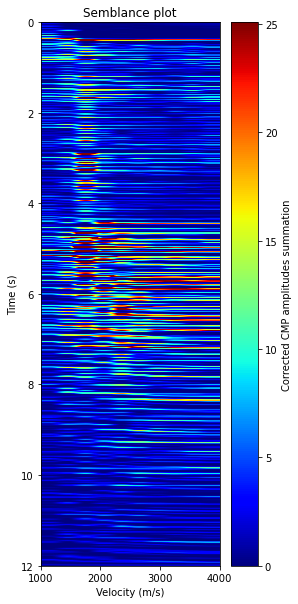

In [52]:
# visualise semblance plot

# clip outlier values for improved visualisation
vm = np.percentile(amp_store.clip(0, np.max(amp_store)), 99) 
vmin, vmax = 0, vm

plt.figure(figsize = (4,10))
plt.imshow(np.swapaxes(amp_store,0,1 )[start:,:].clip(0, np.max(amp_store)),extent=[np.min(v_test), np.max(v_test),
                                            dt*nsamples, 0], aspect="auto",cmap='jet', vmin=vmin, vmax=vmax)

plt.title ('Semblance plot')
plt.colorbar(label = 'Corrected CMP amplitudes summation')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time (s)')
plt.show()

at depth a larger range of velocities will work to make reflection horizontal

**QUESTION: run your previously written functions to obtain an NMO correct CMP** 

[[8, 6]]
[[8, 6], [531, 946]]
NMO_vel=  1000 | time =  0.07200000000000001
NMO_vel=  4000 | time =  11.828


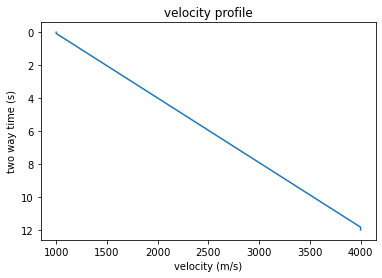

In [65]:
NMO_val = seis.click(amp_store[:, :], v_test, times)
v_nmo = seis.vel_curve (amp_store, NMO_val, times) #timing is wrong, we cut the top part remember!
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo)

Lets visualise our results

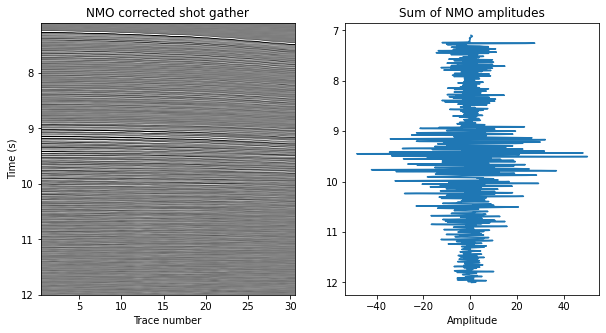

In [61]:
vm = np.percentile(nmo.clip(0, np.max(amp_store)), 99)
vmin, vmax = -vm, vm

fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(nmo[start:,:], extent=[0.5, noffsets + 0.5, np.max(times), cut/1000], 
          aspect="auto", cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title('NMO corrected shot gather')
ax[0].set_xlabel('Trace number')
ax[0].set_ylabel('Time (s)')

ax[1].plot(np.sum(nmo, axis = 1)[start:], times[start:])
ax[1].set_title('Sum of NMO amplitudes')
ax[1].set_xlabel('Amplitude')
ax[1].invert_yaxis()

plt.show()

## Questions

Please submit any exercices and questions you have struggled with and we can take some time at the end of the session to review these:We will take 20 minutes at the end of the class to cover any major questions or problems that have come up. You are encouraged to to ask the GTAs and lecturers during the class, however you can always post them on here as well:
For Ex 2- https://www.menti.com/8ay9gppd8gFor ; code 7541 2015
 
## feedback

Any Feedback on todays practicals would be extremely valuable to improve not just next years content but this Thursday practical. please submit your ideas here:

- https://forms.gle/U5tAJgSXmhgHCumL8

In [ ]:
# References

- notebooks we used
- Rob Allen